Main question: Home vs away's effect on performance. (Does having a race in your country affect performance?)

In [440]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [441]:
races            = pd.read_csv("./dataset/races.csv")
circuits         = pd.read_csv("./dataset/circuits.csv")
constructors     = pd.read_csv("./dataset/constructors.csv")
drivers          = pd.read_csv("./dataset/drivers.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")
demonyms         = pd.read_csv("./dataset/demonyms.csv")

In [442]:
import seaborn as sns
import matplotlib.pyplot as plt

def lookup_country(nationality: str) -> str:
    return demonyms[demonyms['nationality'] == nationality].iloc[0]['country']

def filter_home_or_away_results_only(df, grouping_column, filter_column):
    """Filter out drivers/constructors who have only one at home or not at home
    score remaining.  All drivers/constructors after this filteration should
    have a row at home and outside home"""
    counts = df.groupby([grouping_column])[filter_column].nunique()
    counts = counts[counts > 1]
    return df[df[grouping_column].isin(counts.index)]

def filter_outliers(data, column):
    # Calculate the first and third quartiles of the data
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Filter the data to keep only the rows where the data points fall within the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    return data[(data[column] >= q1 - 1.5*iqr) & (data[column] <= q3 + 1.5*iqr)]

def plot_home_vs_away(df, x, y, hue, title):
    # Set the style and context of the plot
    sns.set_style('whitegrid')
    sns.set_context('talk')

    # Create the grouped bar plot using seaborn
    sns.catplot(y=y, x=x, hue=hue, kind='bar', data=df, height=24, orient='h')

    # Set the plot title and axis labels
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel(x)

    # Show the plot
    plt.show()

def plot_hist(df, data_column, grouping_column):
    away_data = df[df[grouping_column] == False][data_column]
    home_data = df[df[grouping_column] == True][data_column]

    plt.hist(away_data, histtype='step')
    plt.hist(home_data, histtype='step')

    plt.title(f'Histogram distribution of {data_column}')
    plt.legend(['Away', 'Home'])
    plt.ylabel(f'Frequency of {data_column}')
    plt.xlabel(data_column)
    plt.show()


##  Driver performance by points

In [443]:
# Alfonso Thiele had an American-Italian citizenship, but he mainly raced for an italian team
# The same applies for Alessandro de Tomaso.
alfonso_index = drivers[(drivers['forename'] == 'Alfonso') & (drivers['surname'] == 'Thiele')].index
alessandro_index = drivers[(drivers['forename'] == 'Alessandro') & (drivers['surname'] == 'de Tomaso')].index

drivers.loc[alfonso_index, 'nationality'] = 'Italian'
drivers.loc[alessandro_index, 'nationality'] = 'Italian'

# There are multiple east german drivers
drivers[drivers['nationality'] == 'East German'] = 'German'

In [444]:
# Convert nationalities to countries and make sure there are no nans.
display(drivers['nationality'])
drivers['country'] = drivers['nationality'].apply(lookup_country)
assert not drivers['country'].hasnans

0         British
1          German
2          German
3         Spanish
4         Finnish
          ...    
852        German
853       Chinese
854         Dutch
855    Australian
856      American
Name: nationality, Length: 857, dtype: object

In [445]:
races.rename(columns={'name':'race_name'}, inplace=True)
races = races[['raceId', 'circuitId']]

circuits.rename(columns={'name':'circuit_name'}, inplace=True)
circuits = circuits[['circuitId', 'country']]

races_circuits = pd.merge(races, circuits, on='circuitId', how='left')

display(races_circuits)

,raceId,circuitId,country
0,1,1,Australia
1,2,2,Malaysia
2,3,17,China
3,4,3,Bahrain
4,5,4,Spain
...,...,...,...
1097,1116,69,USA
1098,1117,32,Mexico
1099,1118,18,Brazil
1100,1119,80,United States


In [446]:
drivers = drivers[['driverId', 'country']]
drivers.rename(columns={'country': 'driver_country'}, inplace=True)

driver_standings = driver_standings[['raceId', 'driverId', 'points']]
races = races[['raceId', 'circuitId']]

circuits = circuits[['circuitId', 'country']]
circuits.rename(columns={'country': 'circuit_country'}, inplace=True)


# join the dataframes
driver_results = pd.merge(drivers, driver_standings, on='driverId')
driver_race_results = pd.merge(driver_results, races, on='raceId')
driver_circuit_results = pd.merge(driver_race_results, circuits, on='circuitId')
driver_circuit_results.drop(columns=['circuitId', 'raceId'], inplace=True)

display(driver_circuit_results)

df = driver_circuit_results

# Mark each race results as being in the driver's country or not.
df['driver_at_home'] = df['driver_country'] == df['circuit_country']
display(df['driver_at_home'].value_counts())

,driverId,driver_country,points,circuit_country
0,1,United Kingdom,10.0,Australia
1,2,Germany,8.0,Australia
2,3,Germany,6.0,Australia
3,4,Spain,5.0,Australia
4,5,Finland,4.0,Australia
...,...,...,...,...
33882,725,United Kingdom,0.0,Switzerland
33883,741,France,0.0,Switzerland
33884,763,Italy,3.0,Switzerland
33885,764,France,0.0,Switzerland


driver_at_home
False    32299
True      1588
Name: count, dtype: int64

In [447]:
# Get driver ids for results at home and outside home.
home_drivers = set(df[df['driver_at_home'] == True]['driverId'])
away_drivers = set(df[df['driver_at_home'] != True]['driverId'])

# Find the intersection: the drivers who've had races in their home country, and in other countries.
international_drivers = home_drivers.intersection(away_drivers)
home_away_results = df[df['driverId'].isin(international_drivers)]

# Group by the driver id and whether they're at home or not, compute the mean
# for all races of the two groups for each driver, then filter such that we get drivers 
# with meaningful points. (There are a lot of them with just zeros)
home_away_results = home_away_results.groupby(['driverId', 'driver_at_home'])
point_means = home_away_results['points'].mean()
point_means = point_means[point_means > 1].to_frame().reset_index()

display(point_means)

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

,driverId,driver_at_home,points
0,2,False,14.806818
1,2,True,12.444444
2,3,False,82.976923
3,3,True,66.318182
4,4,False,58.563798
...,...,...,...
241,842,False,33.283019
242,842,True,27.000000
243,849,False,1.550000
244,852,False,11.500000


,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,114.0,13.237843,19.872325,1.026316,3.019737,6.387819,13.365211,123.54321
True,114.0,13.622770,29.673948,1.142857,2.400000,5.878571,11.240000,267.25000


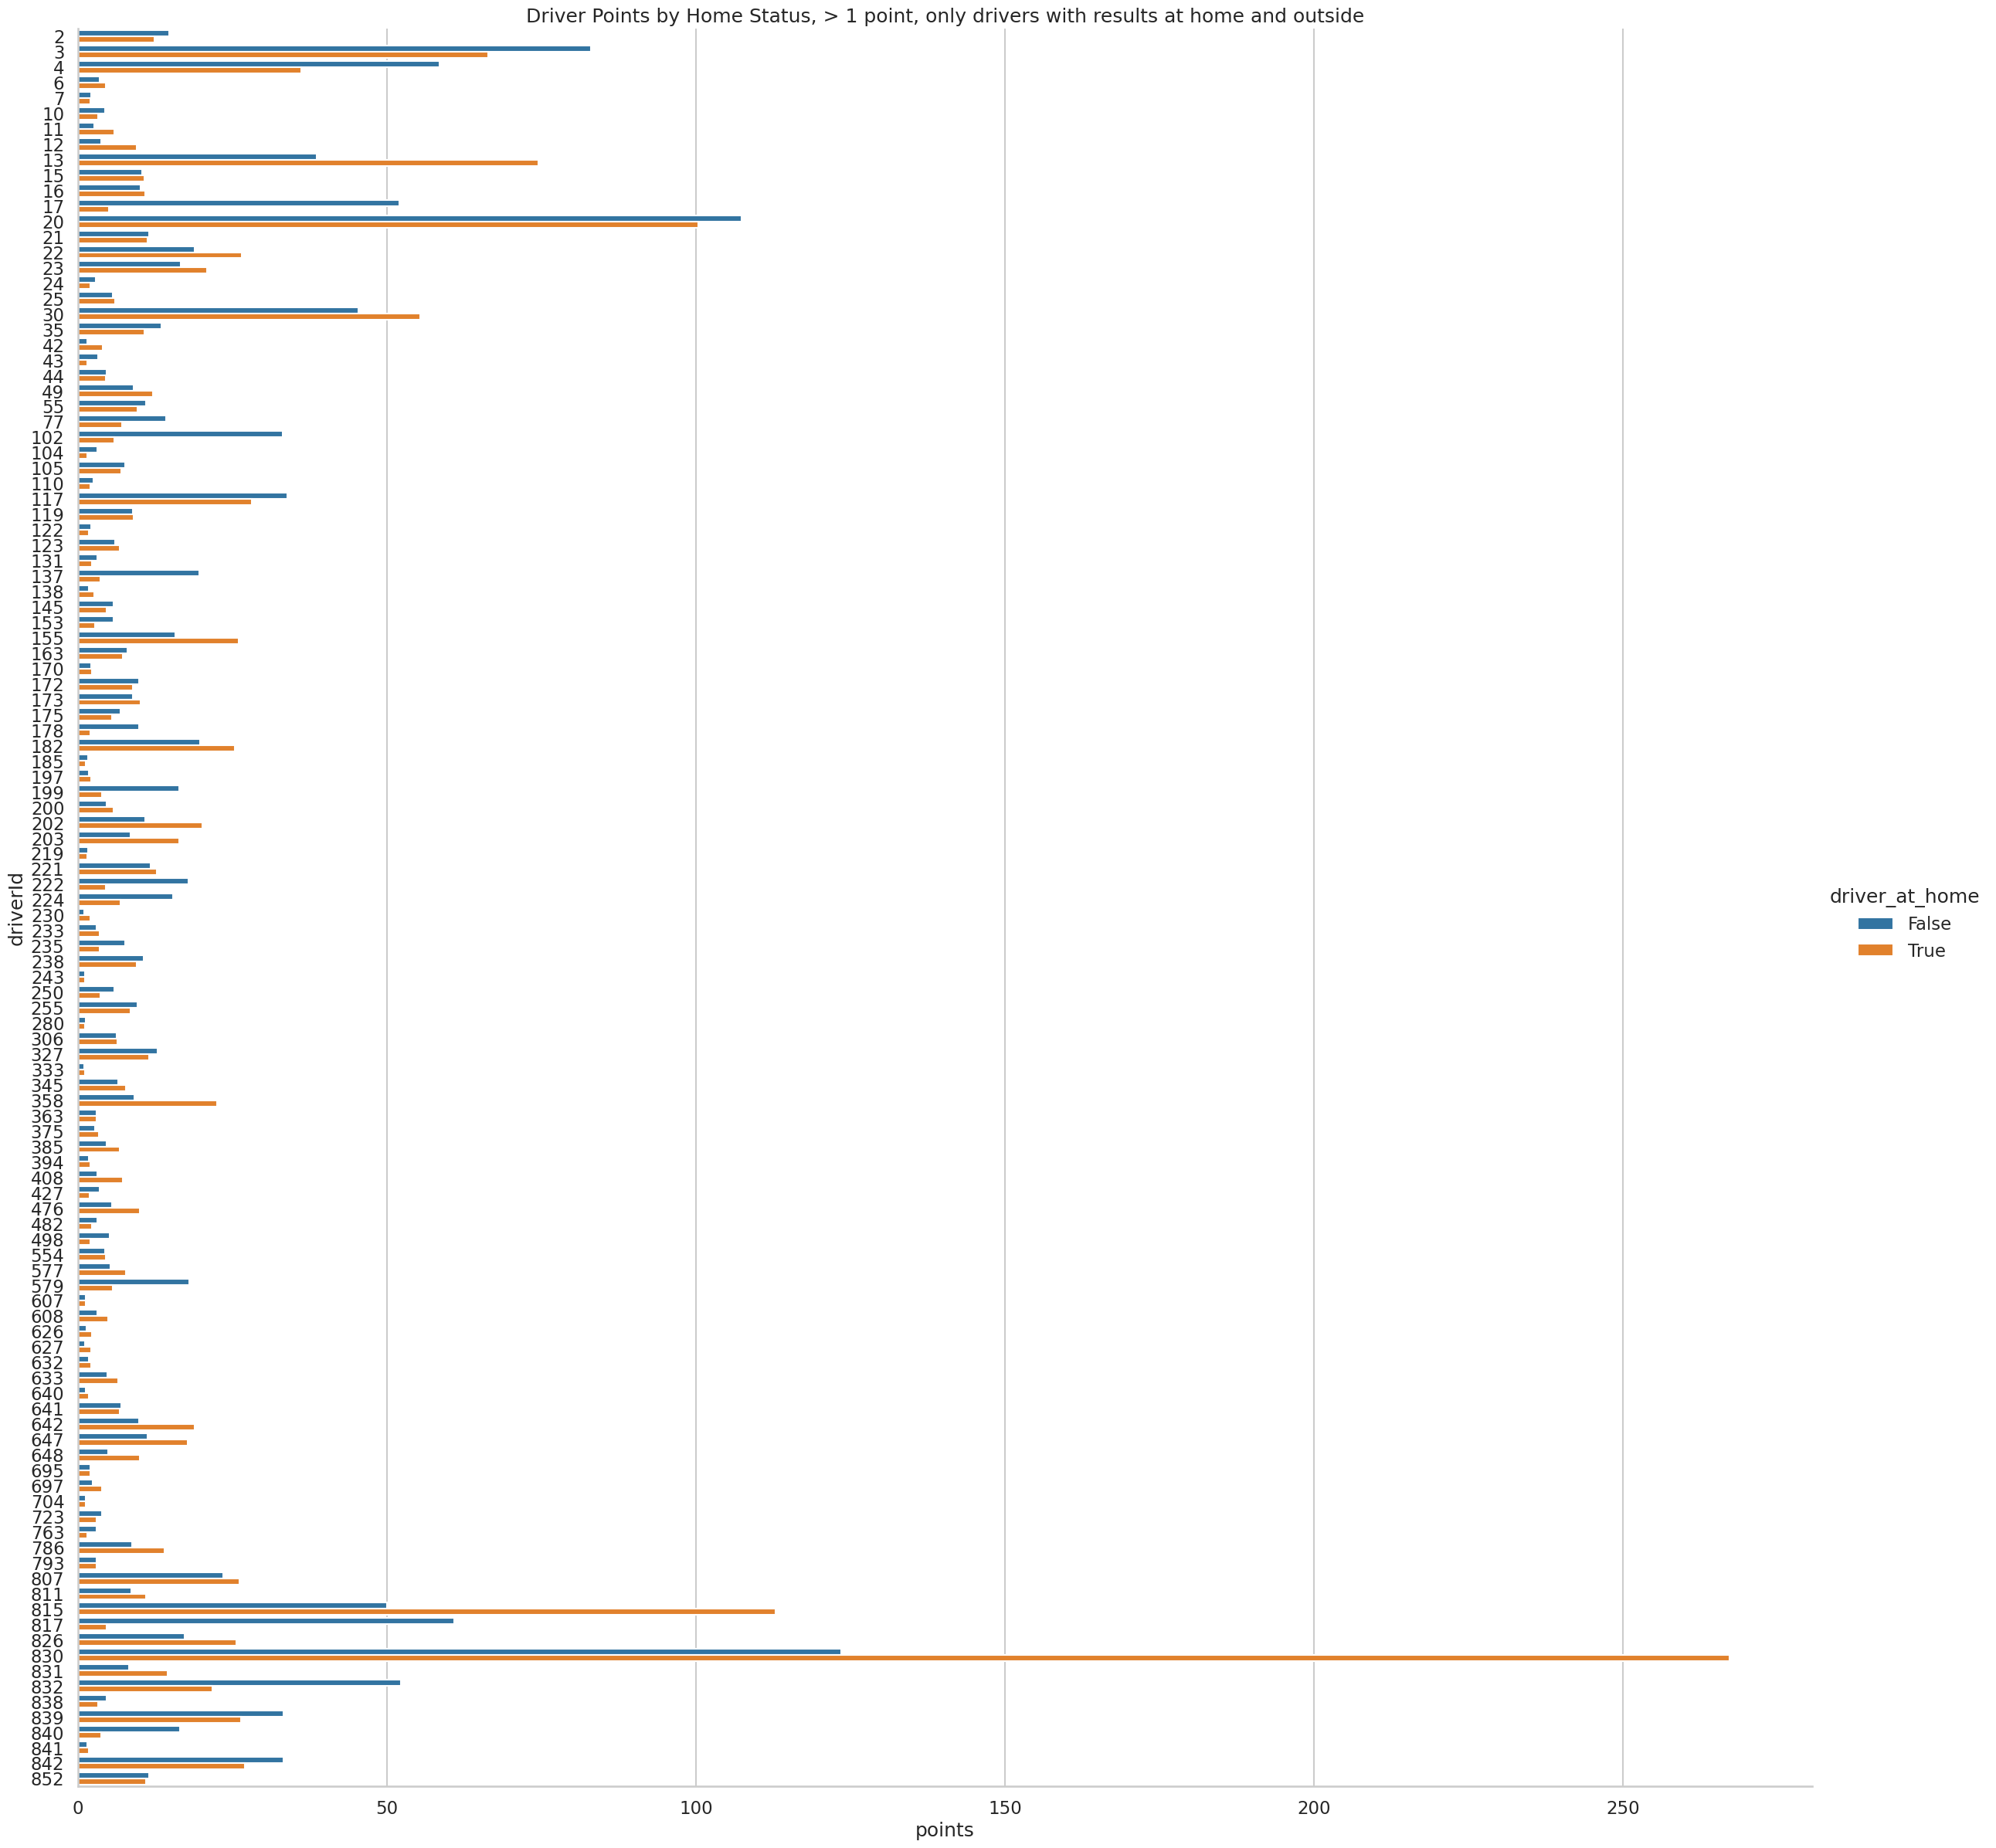

In [448]:
# Notice how there are quite a few outliers?
display(point_means.groupby('driver_at_home')['points'].describe())
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home', 'Driver Points by Home Status, > 1 point, only drivers with results at home and outside')

In [449]:
# The data shows great variation in the values we current have
# might be a good idea to filter it.
home = point_means['driver_at_home'] == True
away = point_means['driver_at_home'] != True

display(point_means.groupby('driver_at_home')['points'].describe())

point_means.loc[home] = filter_outliers(point_means[home], 'points')
point_means.loc[away] = filter_outliers(point_means[away], 'points')

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

display(point_means.groupby('driver_at_home')['points'].describe())

,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,114.0,13.237843,19.872325,1.026316,3.019737,6.387819,13.365211,123.54321
True,114.0,13.622770,29.673948,1.142857,2.400000,5.878571,11.240000,267.25000


,count,mean,std,min,25%,50%,75%,max
driver_at_home,,,,,,,,
False,95.0,6.406596,4.710883,1.026316,2.717172,4.916667,9.428922,19.670918
True,95.0,6.230365,4.950235,1.142857,2.183333,4.500000,9.233333,22.500000


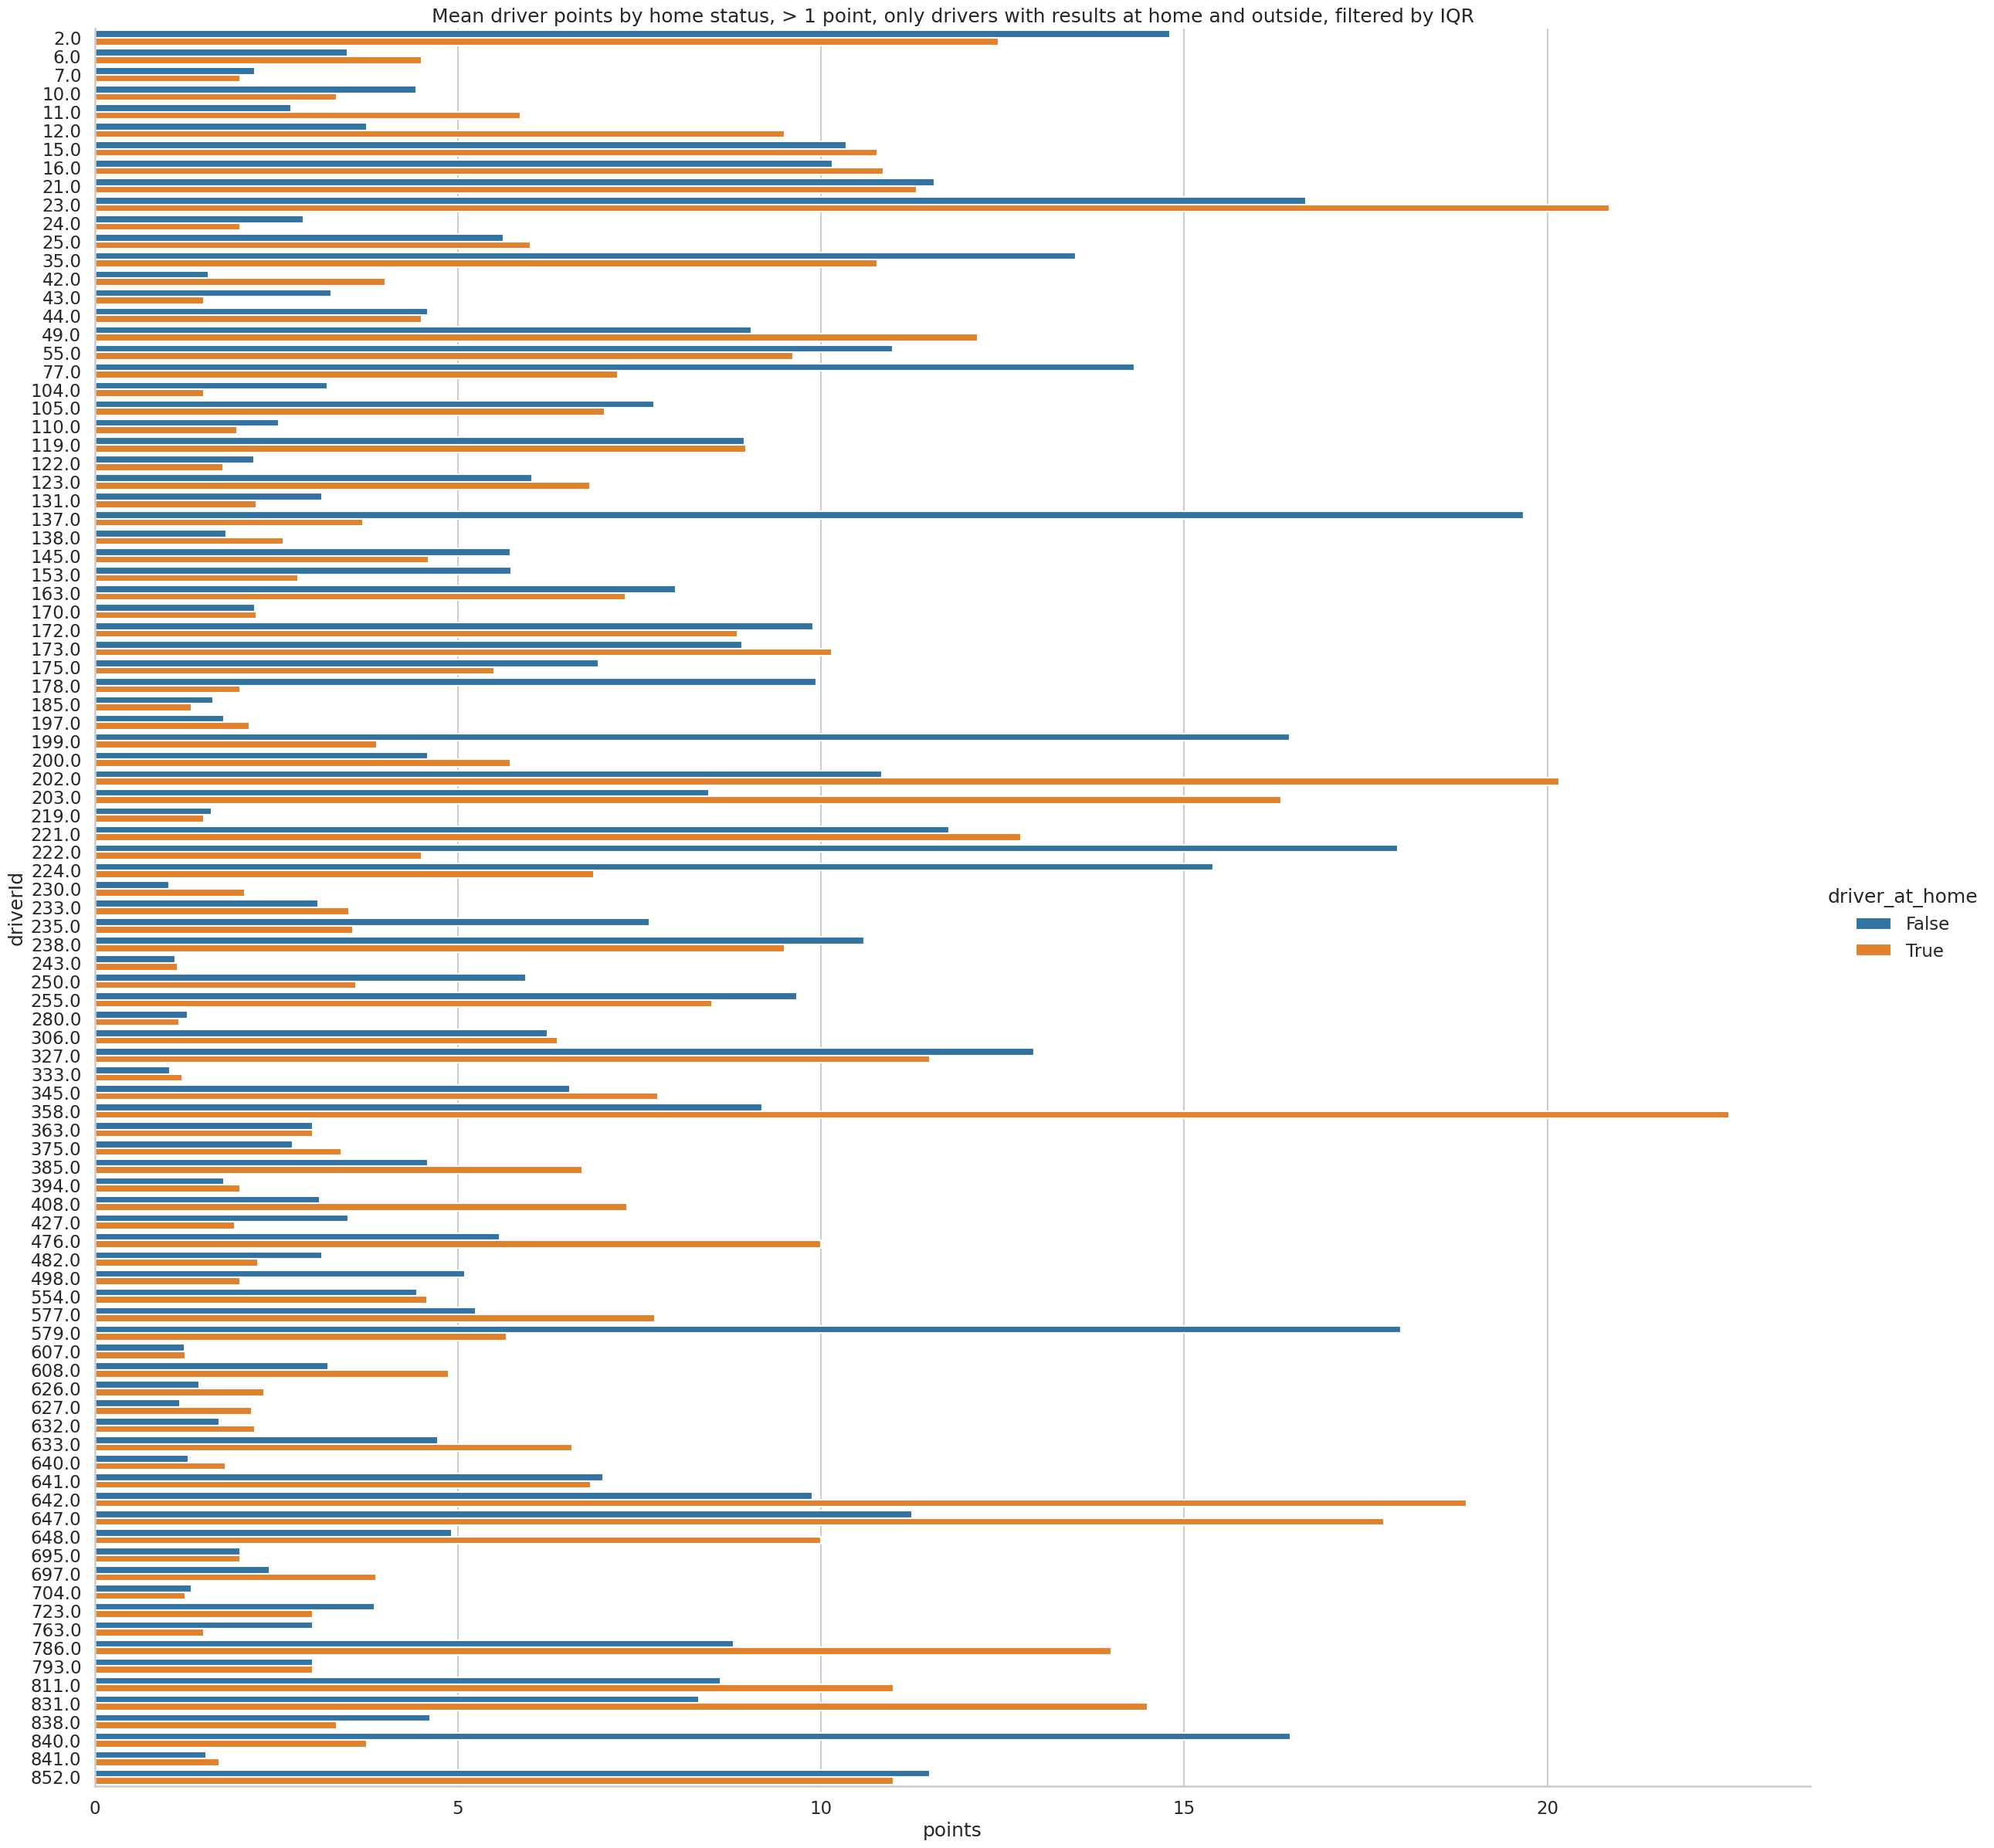

In [450]:
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home',  'Mean driver points by home status, > 1 point, only drivers with results at home and outside, filtered by IQR')

In [451]:
mean_at_home = point_means[point_means['driver_at_home'] == True]['points'].mean()
mean_outside = point_means[point_means['driver_at_home'] != True]['points'].mean()

print(f"Mean points over all drivers and races at home: {mean_at_home}, outside home: {mean_outside}")

Mean points over all drivers and races at home: 6.230365154748811, outside home: 6.406595869603917


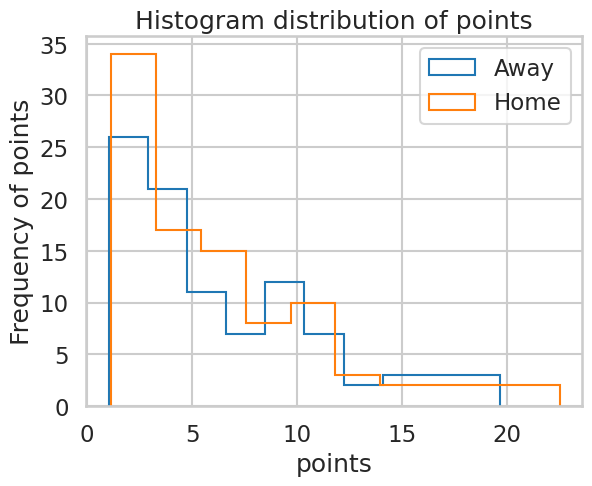

In [452]:
plot_hist(point_means, 'points', 'driver_at_home')

## Constructor performance by wins

In [453]:
constructor_standings = pd.read_csv('./dataset/constructor_standings.csv')
df = pd.merge(constructors, constructor_standings, on='constructorId', how='left')
df = df.merge(races, on='raceId', how='left')
df = df.merge(circuits, on='circuitId', how='left')

df[df['nationality'] == 'East German'] = 'German'
df['constructor_country'] = df['nationality'].apply(lookup_country)
df['constructor_at_home'] = df['constructor_country'] == df['circuit_country']

display(df)

,constructorId,constructorRef,name,nationality,url,constructorStandingsId,raceId,points,position,positionText,wins,circuitId,circuit_country,constructor_country,constructor_at_home
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,1.0,18.0,14.0,1.0,1,1.0,1.0,Australia,United Kingdom,False
1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,7.0,19.0,24.0,1.0,1,1.0,2.0,Malaysia,United Kingdom,False
2,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,18.0,20.0,28.0,3.0,3,1.0,3.0,Bahrain,United Kingdom,False
3,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,29.0,21.0,34.0,3.0,3,1.0,4.0,Spain,United Kingdom,False
4,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,40.0,22.0,42.0,3.0,3,1.0,5.0,Turkey,United Kingdom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12988,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28367.0,1093.0,149.0,4.0,4,0.0,69.0,USA,France,False
12989,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28377.0,1094.0,153.0,4.0,4,0.0,32.0,Mexico,France,False
12990,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28387.0,1095.0,167.0,4.0,4,0.0,18.0,Brazil,France,False
12991,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28397.0,1096.0,173.0,4.0,4,0.0,24.0,UAE,France,False


In [454]:
constructor_ids_at_home = set(df[df['constructor_at_home'] == True]['constructorId'])
constructor_ids_away = set(df[df['constructor_at_home'] != True]['constructorId'])
constructor_ids_home_and_away = constructor_ids_at_home.intersection(constructor_ids_away)
df = df[df['constructorId'].isin(constructor_ids_home_and_away)]

df = filter_home_or_away_results_only(df, 'constructorId', 'constructor_at_home')

display(df)

,constructorId,constructorRef,name,nationality,url,constructorStandingsId,raceId,points,position,positionText,wins,circuitId,circuit_country,constructor_country,constructor_at_home
884,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,2.0,18.0,8.0,3.0,3,0.0,1.0,Australia,Germany,False
885,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,8.0,19.0,19.0,2.0,2,0.0,2.0,Malaysia,Germany,False
886,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,19.0,20.0,30.0,1.0,1,0.0,3.0,Bahrain,Germany,False
887,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,30.0,21.0,35.0,2.0,2,0.0,4.0,Spain,Germany,False
888,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,41.0,22.0,44.0,2.0,2,0.0,5.0,Turkey,Germany,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12988,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28367.0,1093.0,149.0,4.0,4,0.0,69.0,USA,France,False
12989,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28377.0,1094.0,153.0,4.0,4,0.0,32.0,Mexico,France,False
12990,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28387.0,1095.0,167.0,4.0,4,0.0,18.0,Brazil,France,False
12991,214,alpine,Alpine F1 Team,French,http://en.wikipedia.org/wiki/Alpine_F1_Team,28397.0,1096.0,173.0,4.0,4,0.0,24.0,UAE,France,False


In [461]:
df = df[['constructorId', 'wins', 'constructor_at_home']]

df = df.groupby(['constructorId', 'constructor_at_home']).aggregate('mean').reset_index()
df['wins'] = df['wins'].convert_dtypes(convert_floating=True)
df = df[df['wins'] > 0]
df = filter_home_or_away_results_only(df, 'constructorId', 'constructor_at_home')


display(df)

,constructorId,constructor_at_home,wins
0,2,False,0.169231
1,2,True,0.2
2,4,False,0.842784
3,4,True,1.388889
4,5,False,0.01581
5,5,True,0.066667
6,6,False,1.87037
7,6,True,2.168421
8,9,False,2.590504
9,9,True,2.272727


,count,mean,std,min,25%,50%,75%,max
constructor_at_home,,,,,,,,
False,13.0,1.131059,1.412412,0.01581,0.127273,0.466667,1.87037,4.629482
True,13.0,1.248885,1.421461,0.066667,0.272727,0.6875,2.168421,5.0


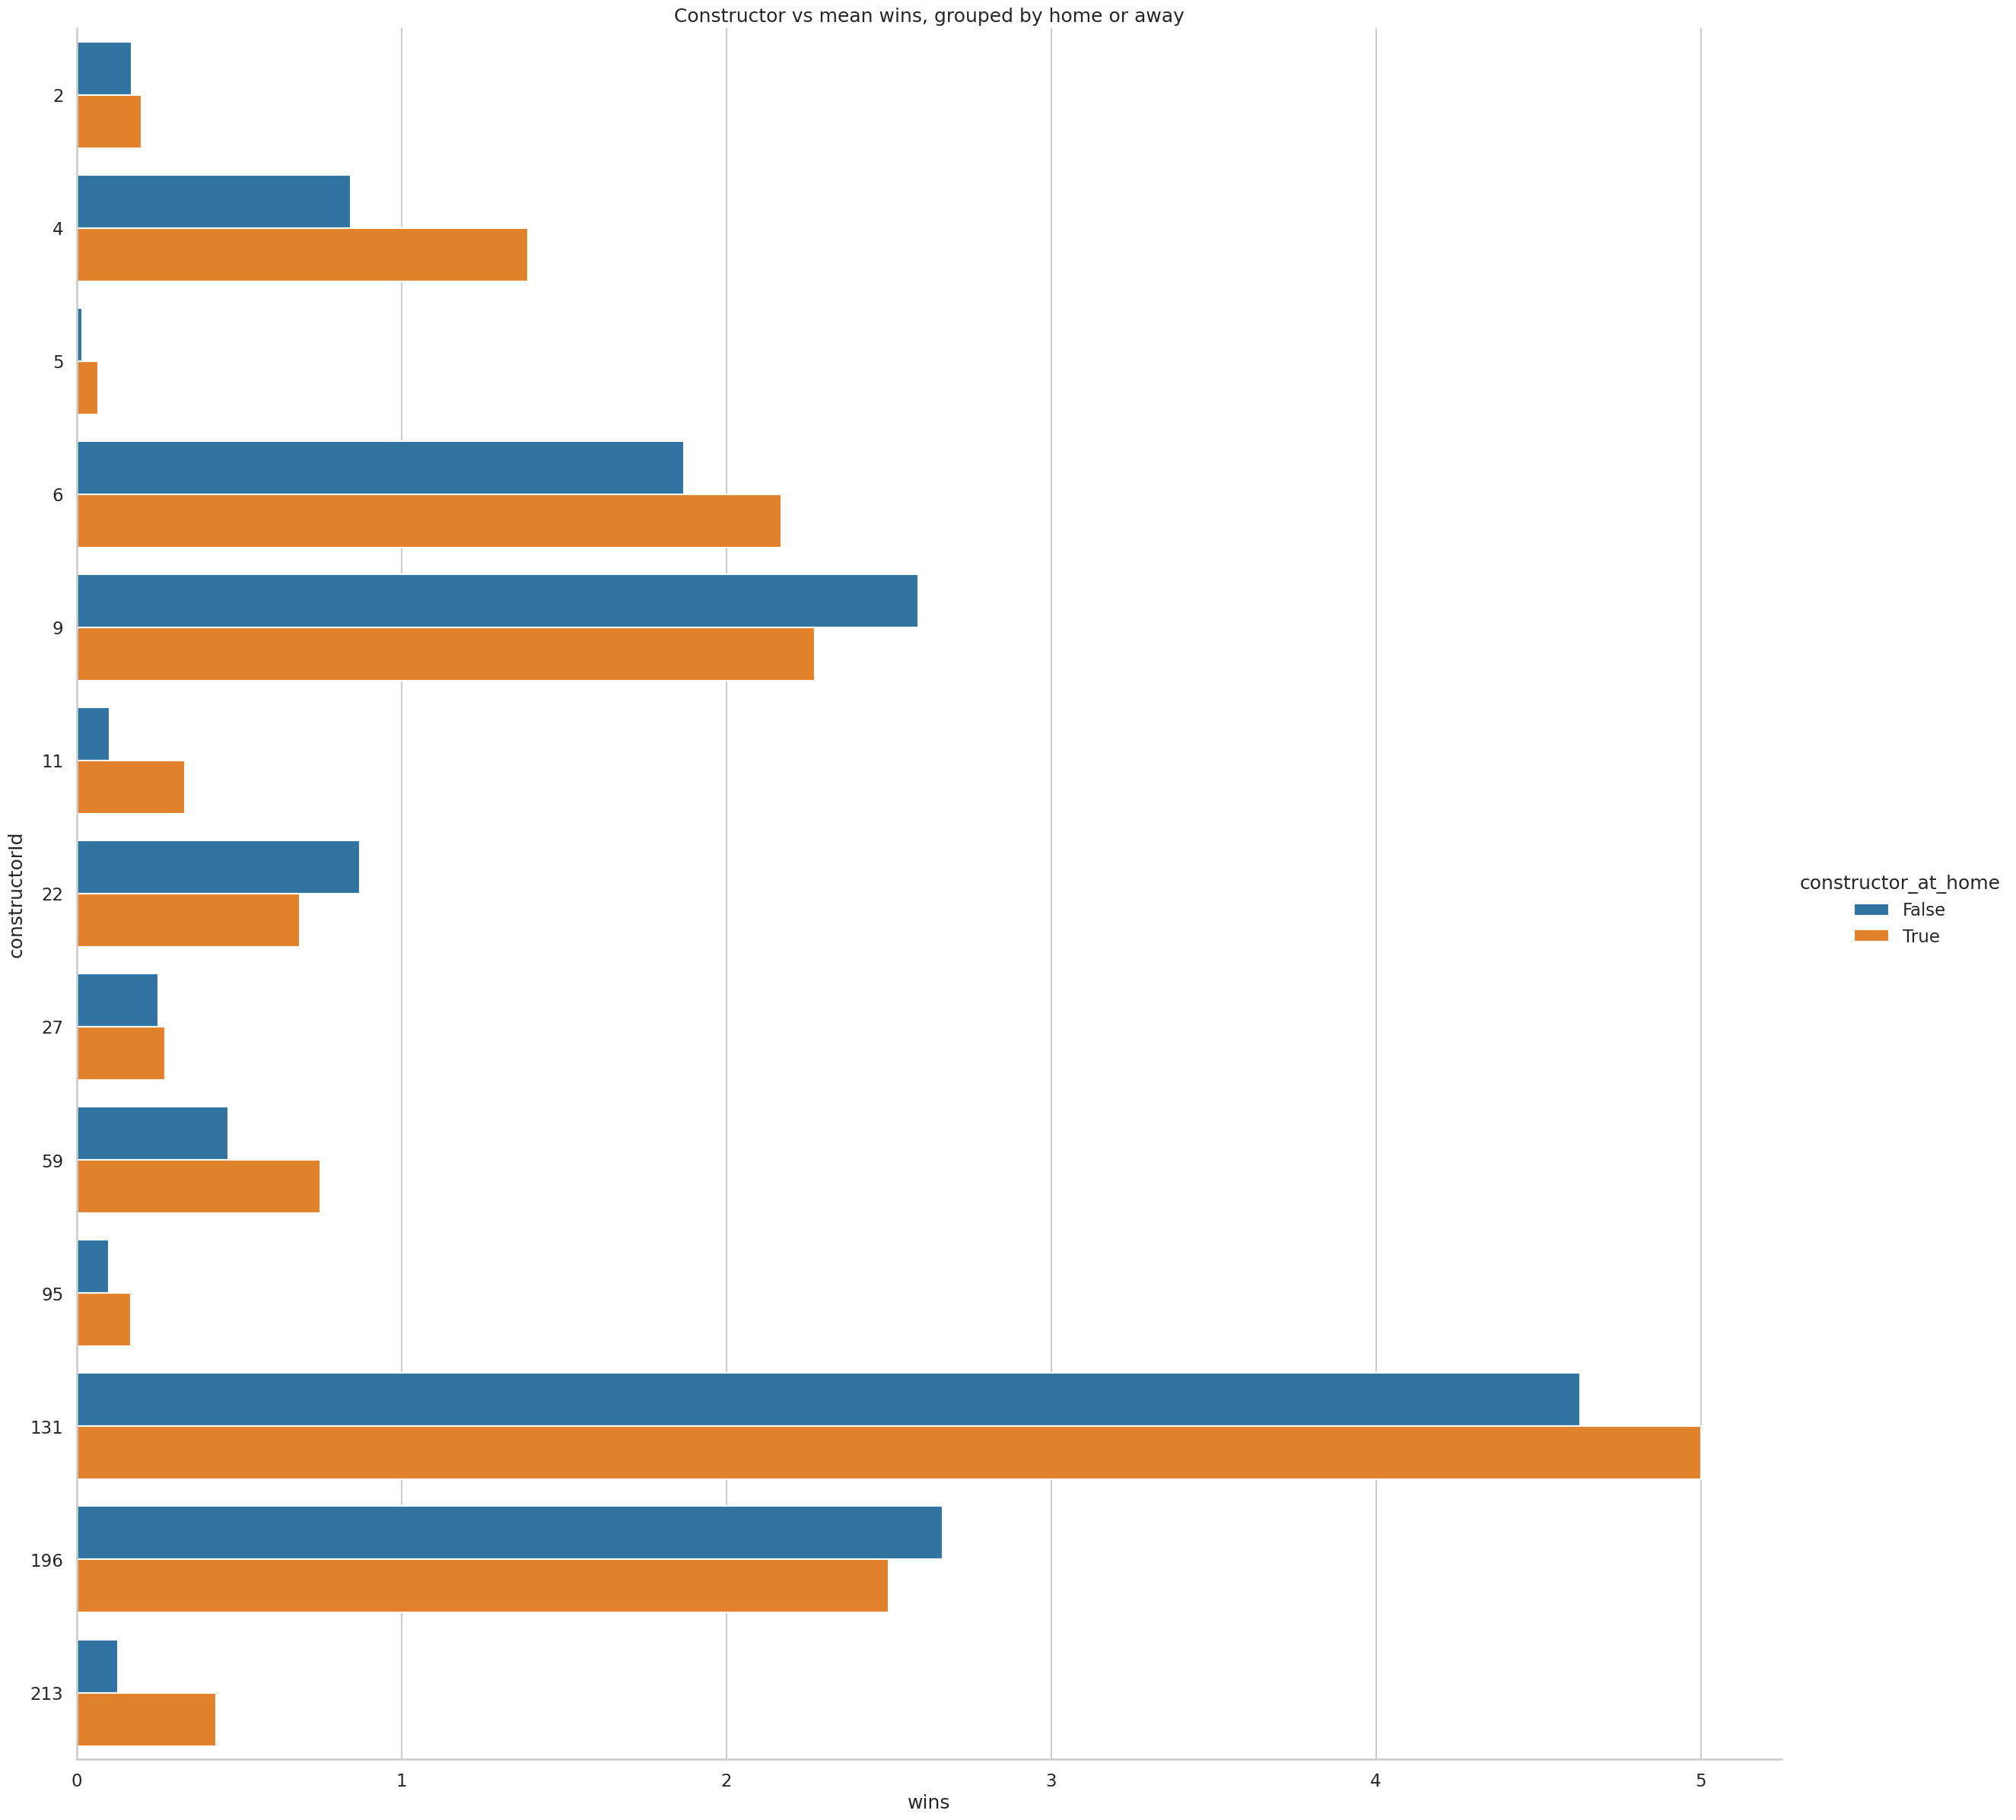

In [464]:
display(df.groupby(['constructor_at_home'])['wins'].describe())
plot_home_vs_away(df, 'wins', 'constructorId', 'constructor_at_home', 'Constructor vs mean wins, grouped by home or away')

,count,mean,std,min,25%,50%,75%,max
constructor_at_home,,,,,,,,
False,12.0,0.839524,0.985347,0.01581,0.120735,0.35914,1.121778,2.666667
True,12.0,0.936292,0.904694,0.066667,0.254545,0.558036,1.583772,2.5


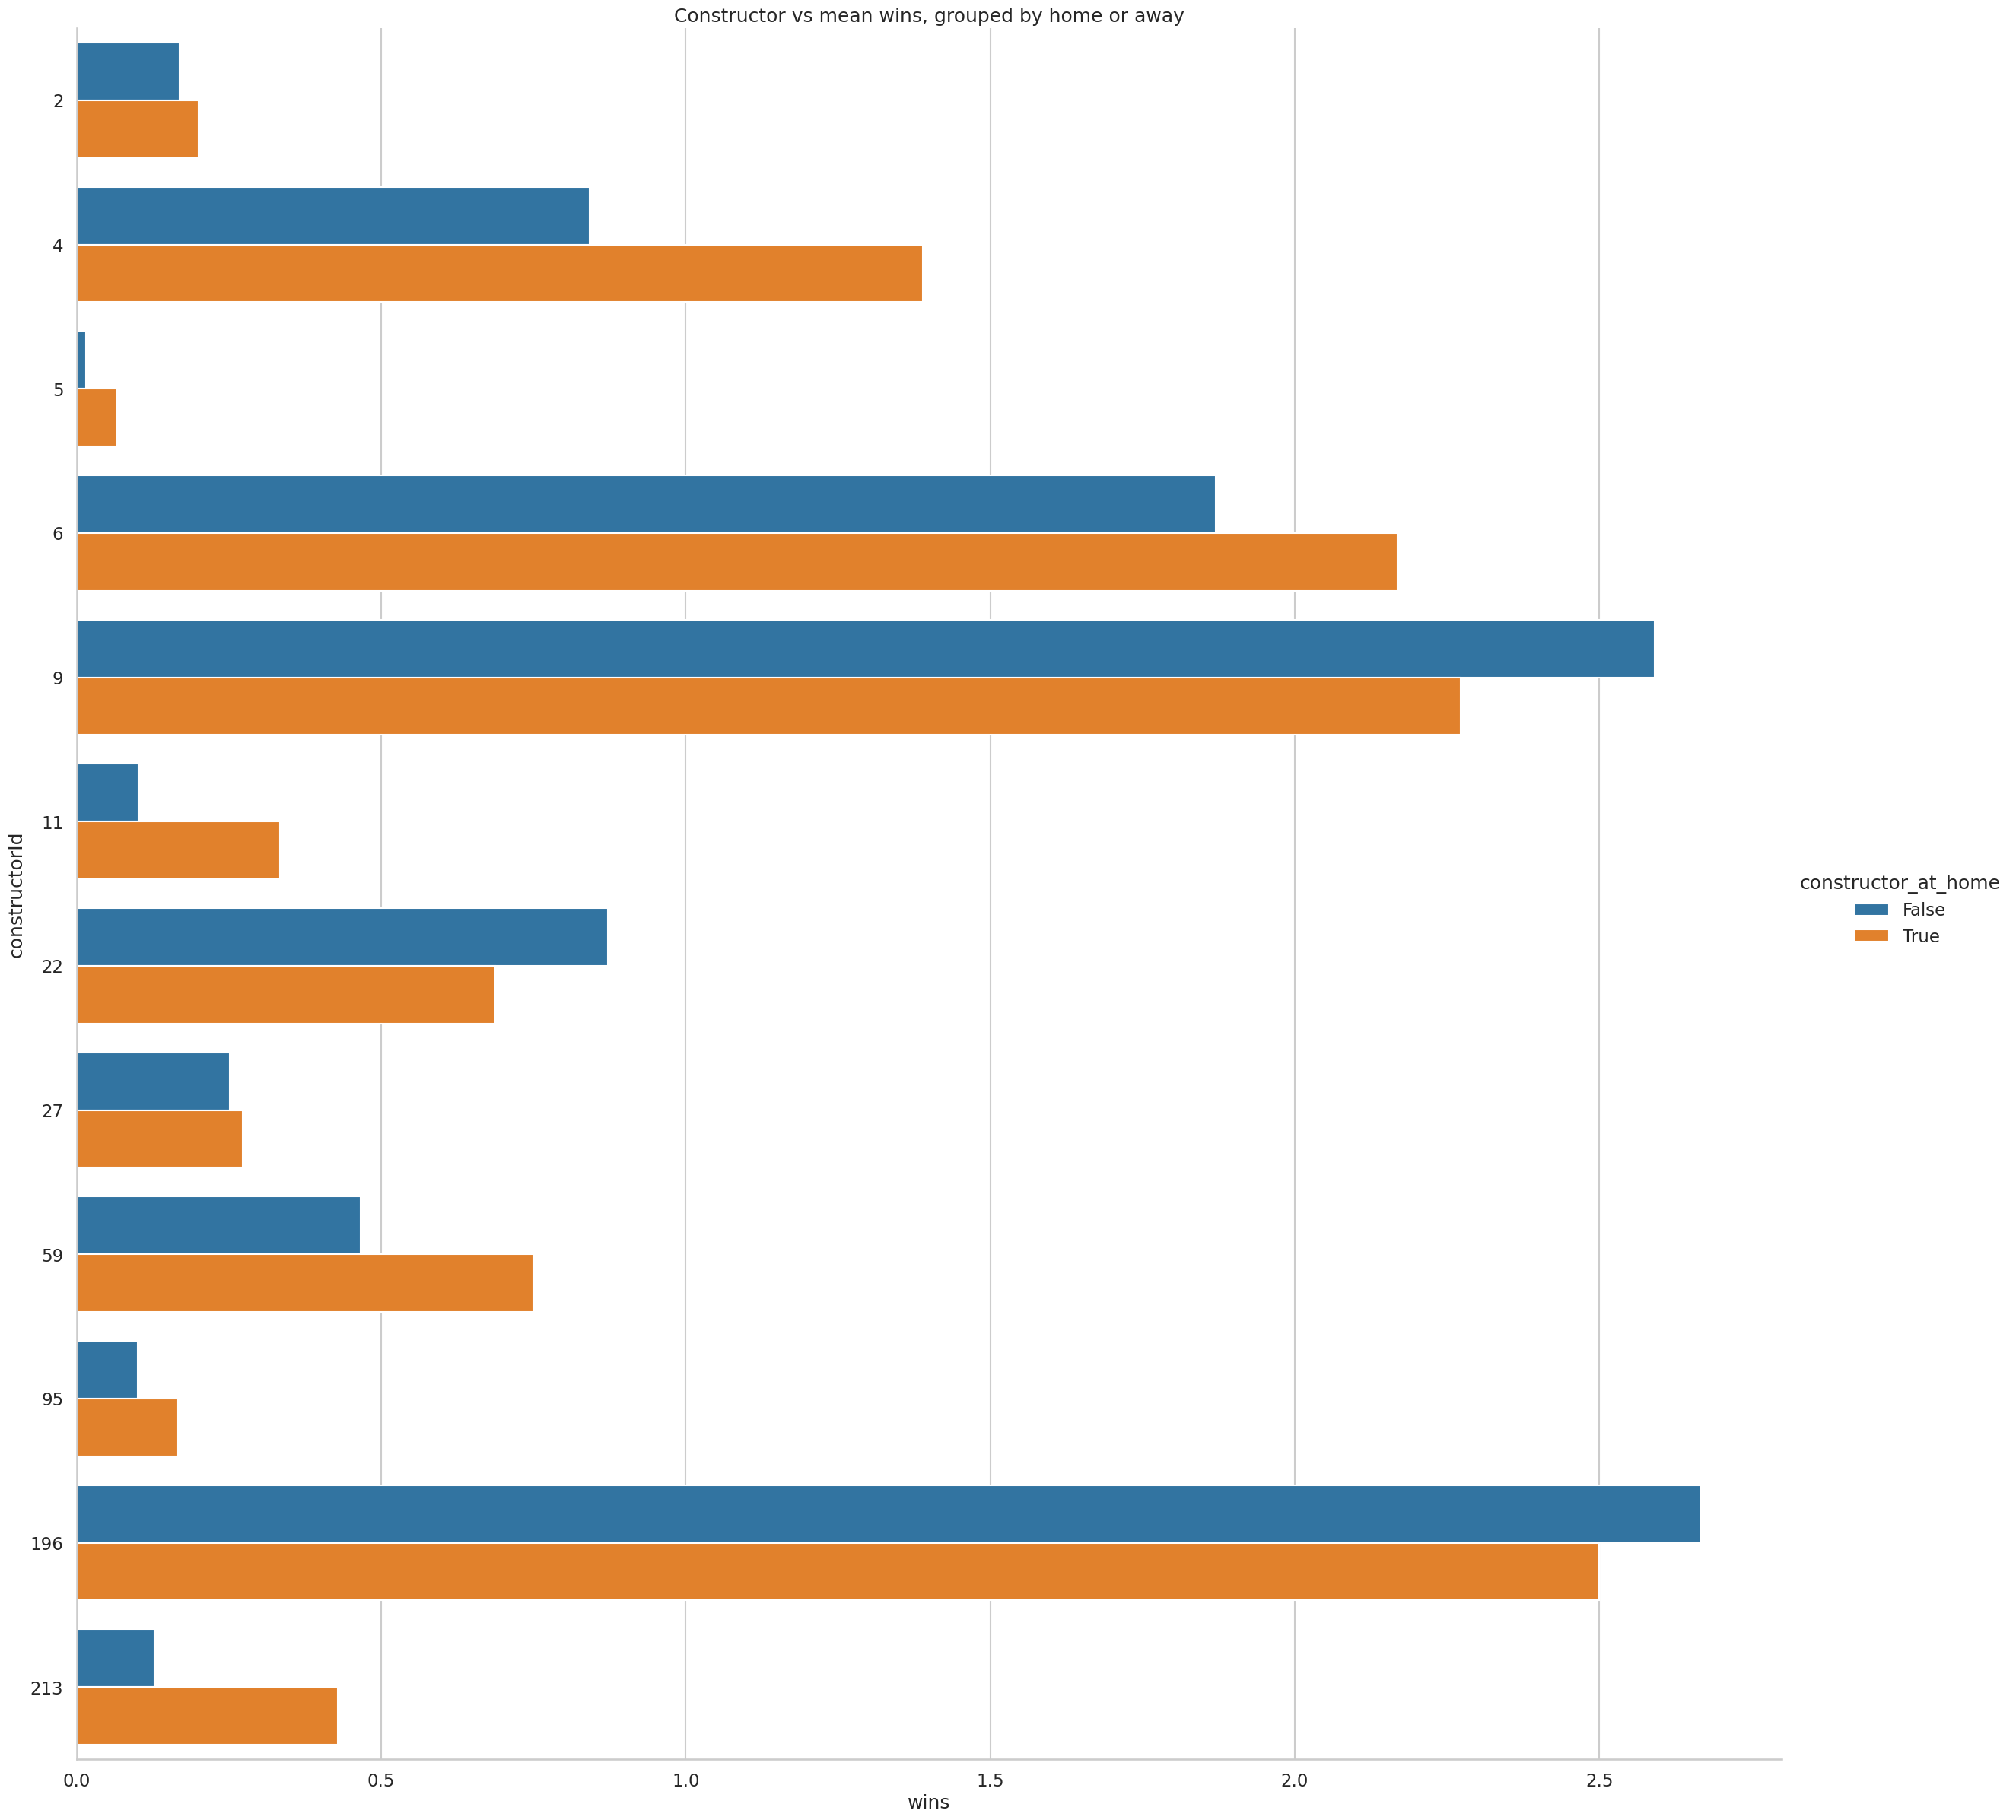

In [467]:
df = filter_outliers(df, 'wins')
df = filter_home_or_away_results_only(df, 'constructorId', 'constructor_at_home')

display(df.groupby('constructor_at_home')['wins'].describe())
plot_home_vs_away(df, 'wins', 'constructorId', 'constructor_at_home', 'Constructor vs mean wins, grouped by home or away')